In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import bte

To replicate this analysis, you will need to obtain the relevant phylogeny and generate novel lineages. Instead of applying the full Snakemake pipeline for Pango designations, this can be done directly using the core implementation script at https://github.com/jmcbroome/autolin/blob/main/propose_sublineages.py. 

```

wget http://hgdownload.soe.ucsc.edu/goldenPath/wuhCor1/UShER_SARS-CoV-2/2022/12/11/public-2022-12-11.all.masked.pb.gz

python3 propose_sublineages.py -i public-2022-12-11.all.masked.pb.gz -c -r -o public-2022-12-11.fresh_annotations.pb -d fresh_annotations.tsv -l fresh_annotations.labels.tsv -t 1 -m 10 --verbose > fresh_annotations.log

```

Once this is done, we load in the original phylogeny, and apply a simple algorithm to identify, for each node on the tree, the number of descendent tips.

In [2]:
t = bte.MATree("public-2022-12-11.all.masked.pb.gz")
t

Finished 'from_pb' in 62.8205 seconds


MATree object with 6518699 leaves.

In [4]:
node_desc_counts = {}
for n in t.breadth_first_expansion(reverse=True):
    if n.is_leaf():
        node_desc_counts[n.id] = 1
    else:
        node_desc_counts[n.id] = sum([node_desc_counts[c.id] for c in n.children])
len(node_desc_counts)

7835901

We then load in the mappings of the pango (and nextstrain) clades and the new Autolin lineages. These files can be obtained from the public phylogeny and from the newly annotated phylogeny with `matUtils extract -C`.

In [20]:
auto_pdf = pd.read_csv('fresh_annotations_paths.txt',sep='\t',usecols=[0,1])
pango_pdf = pd.read_csv('pango_paths.txt',sep='\t',usecols=[0,1])
auto_pdf

,clade,root_id
0,L,node_1
1,auto.L.6,node_600562
2,auto.L.6.285,node_601050
3,auto.L.6.235,node_601053
4,auto.L.6.212,node_601056
...,...,...
150025,auto.L.2.1.2.4.1.1.3.1,node_1175339
150026,auto.L.2.1.2.4.1.1.1.1.1.2.1,node_1175511
150027,auto.L.2.1.2.4.1.1.1.1.1.1.1,node_1175474
150028,auto.L.2.1.2.4.1.1.3.1.1,node_1175348


We then compute the pairwise Jaccard similarities for each pair of Autolin and Pango/Nextclade lineages that overlap to any degree.

We can speed up this computation by taking advantage of the nature of the shared phylogeny. Since the set of descendent samples is defined by a specific node, and the descendents of the parent of that specific node also includes all descendents of the node by definition, we only need ancestral node identifiers to identify overlapping sample sets. 

Additionally, as lineages are defined as single ancestral nodes on the tree in both cases, there cannot be a case of partial overlap between two lineages. Two lineages can only be:

1. Non-overlapping, with no tips in common 
2. Identical, with all tips in common 
3. Encompassing, where all of the tips in one lineage are present in the other, but not vice versa. 

In the first case, Jaccard is 0; in the second, its 1. We can identify the third case by examining each ancestor of a lineage's root node and checking whether that ancestor is the root of a lineage in the comparison set; if so, that ancestor's descendents will necessarily encompass all the descendents of the first lineage's root node. The set intersection between their descendents is the number of descendent tips of the ancestor, the union is the number of tips of the original descendent lineage, and therefore the jaccard index is simply the first number of descendents divided by the second.

In [103]:
pango_ancestors = pango_pdf.set_index('root_id')['clade'].to_dict()
auto_ancestors = auto_pdf.set_index('root_id')['clade'].to_dict()

In [118]:
pairdf = {k:[] for k in ['pango_lineage','auto_lineage','jaccard','ancestral','ancestral_size','descendent_size']}

for i,row in auto_pdf.iterrows():
    smaller_count = node_desc_counts[row.root_id]
    for anc in t.rsearch(row.root_id,include_self=True):
        pango = pango_ancestors.get(anc.id,None)
        if pango != None:
            bigger_count = node_desc_counts[anc.id]
            pairdf['pango_lineage'].append(pango)
            pairdf['auto_lineage'].append(row.clade)
            pairdf['jaccard'].append(smaller_count/bigger_count)
            pairdf['ancestral'].append('pango')
            pairdf['ancestral_size'].append(bigger_count)
            pairdf['descendent_size'].append(smaller_count)

            
for i,row in pango_pdf.iterrows():
    smaller_count = node_desc_counts[row.root_id]
    for anc in t.rsearch(row.root_id,include_self=True):
        auto = auto_ancestors.get(anc.id,None)
        if auto != None:
            bigger_count = node_desc_counts[anc.id]
            pairdf['pango_lineage'].append(row.clade)
            pairdf['auto_lineage'].append(auto)
            pairdf['jaccard'].append(smaller_count/bigger_count)
            pairdf['ancestral'].append('auto')
            pairdf['ancestral_size'].append(bigger_count)
            pairdf['descendent_size'].append(smaller_count)

pairdf = pd.DataFrame(pairdf)
pairdf

,pango_lineage,auto_lineage,jaccard,ancestral,ancestral_size,descendent_size
0,B,L,1.000000,pango,6518699,6518699
1,B.1,auto.L.6,0.040205,pango,6500291,261342
2,B,auto.L.6,0.040091,pango,6518699,261342
3,20C,auto.L.6.285,0.000118,pango,143953,17
4,B.1,auto.L.6.285,0.000003,pango,6500291,17
...,...,...,...,...,...,...
869955,BQ.1.8.2,auto.L.2.1.1.3,0.009528,auto,27812,265
869956,BQ.1.8.2,auto.L.2.1.1,0.000544,auto,486908,265
869957,BQ.1.8.2,auto.L.2.1,0.000167,auto,1587168,265
869958,BQ.1.8.2,auto.L.2,0.000104,auto,2558909,265


The above treats Pango and Nextclade clades interchangeably. We can identify whether a given clade is a Nextstrain clade or a Pango lineage by its position in the annotation vector in the original phylogeny.

In [119]:
nextstrain_clades = []
for n in t.depth_first_expansion():
    if len(n.annotations) > 0:
        if n.annotations[0] != "":
            nextstrain_clades.append(n.annotations[0])
nextstrain_clades

['19A',
 '19B',
 '20A',
 '21B (Kappa)',
 '21A (Delta)',
 '21J (Delta)',
 '21I (Delta)',
 '20E (EU1)',
 '21D (Eta)',
 '20C',
 '21C (Epsilon)',
 '21F (Iota)',
 '20H (Beta,V2)',
 '21H (Mu)',
 '20G',
 '20B',
 '21E (Theta)',
 '20D',
 '21G (Lambda)',
 '20F',
 '21M (Omicron)',
 '21K (Omicron)',
 '21L (Omicron)',
 '22A (Omicron)',
 '22B (Omicron)',
 '22E (Omicron)',
 '22F (Omicron)',
 '22D (Omicron)',
 '22C (Omicron)',
 '20I (Alpha,V1)',
 '20J (Gamma,V3)']

In [120]:
pairdf['is_nextstrain'] = pairdf['pango_lineage'].apply(lambda x:x in nextstrain_clades)
pairdf

,pango_lineage,auto_lineage,jaccard,ancestral,ancestral_size,descendent_size,is_nextstrain
0,B,L,1.000000,pango,6518699,6518699,False
1,B.1,auto.L.6,0.040205,pango,6500291,261342,False
2,B,auto.L.6,0.040091,pango,6518699,261342,False
3,20C,auto.L.6.285,0.000118,pango,143953,17,True
4,B.1,auto.L.6.285,0.000003,pango,6500291,17,False
...,...,...,...,...,...,...,...
869955,BQ.1.8.2,auto.L.2.1.1.3,0.009528,auto,27812,265,False
869956,BQ.1.8.2,auto.L.2.1.1,0.000544,auto,486908,265,False
869957,BQ.1.8.2,auto.L.2.1,0.000167,auto,1587168,265,False
869958,BQ.1.8.2,auto.L.2,0.000104,auto,2558909,265,False


13 of the 30 Nextstrain clades have a near-exact or exact matching Autolin lineage, though the case of 19A and 20A is trivial. These include major VOC such as Omicron, Delta, Epsiolon, Mu, and Iota. Some of the smaller VOC are not replicated independently by Autolin, however, such as Eta and Lambda. 

In [121]:
best_matches = pairdf.sort_values("jaccard",ascending=False).drop_duplicates('pango_lineage')
best_matches[best_matches.is_nextstrain].sort_values('jaccard',ascending=False)

,pango_lineage,auto_lineage,jaccard,ancestral,ancestral_size,descendent_size,is_nextstrain
864917,20G,auto.L.6.1,1.000000,auto,73286,73286,True
33036,21I (Delta),auto.L.4,1.000000,pango,191745,191745,True
863564,19A,L,1.000000,auto,6518699,6518699,True
865223,21C (Epsilon),auto.L.6.2,1.000000,auto,41515,41515,True
866542,22D (Omicron),auto.L.2.1.6,1.000000,auto,8337,8337,True
866473,22F (Omicron),auto.L.2.1.9.1,1.000000,auto,1609,1609,True
866456,22A (Omicron),auto.L.2.1.4,1.000000,auto,78100,78100,True
869110,22E (Omicron),auto.L.2.1.1.3,1.000000,auto,27812,27812,True
5944,21M (Omicron),auto.L.2,1.000000,pango,2558910,2558909,True
381964,21J (Delta),auto.L.1,0.999916,pango,2561940,2561724,True


Excluding Nextstrain clades and artifactual annotations (including "misc" and "proposed" tags), there are 1978 annotated Pango lineages in this phylogeny.

In [125]:
pango_pairdf = pairdf[(~pairdf.is_nextstrain) & (pairdf.pango_lineage.apply(lambda x:('misc' not in x) and ('proposed' not in x)))]
pango_pairdf.pango_lineage.nunique()

1978

We can identify the highest matching jaccard for each of these groups by sorting and dropping entries for a specific Pango lineage after the first one.

In [126]:
best_pango_matches = pango_pairdf.sort_values("jaccard",ascending=False).drop_duplicates('pango_lineage')

<AxesSubplot: ylabel='Frequency'>

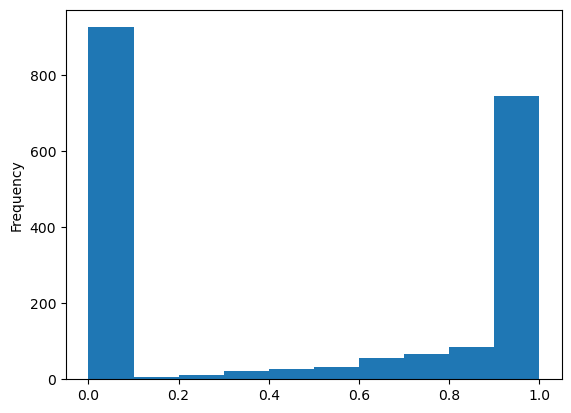

In [127]:
best_pango_matches.jaccard.plot(kind='hist')

In [128]:
best_pango_matches[best_pango_matches.jaccard == 1]

,pango_lineage,auto_lineage,jaccard,ancestral,ancestral_size,descendent_size,is_nextstrain
0,B,L,1.0,pango,6518699,6518699,False
866902,BN.2.1,auto.L.2.1.6.25,1.0,auto,19,19,False
376480,XAU,auto.L.2.1.3.39.4,1.0,pango,21,21,False
376450,XQ,auto.L.2.1.3.35.3,1.0,pango,135,135,False
866647,XBB.2,auto.L.2.1.9.1.2,1.0,auto,226,226,False
...,...,...,...,...,...,...,...
608679,CK.1,auto.L.2.1.1.1.1.50,1.0,pango,202,202,False
868986,CP.1,auto.L.2.1.1.1.1.10.3,1.0,auto,322,322,False
607269,CR.2,auto.L.2.1.1.1.1.113,1.0,pango,50,50,False
868971,CF.1,auto.L.2.1.1.1.1.17.6,1.0,auto,64,64,False


In [129]:
best_pango_matches[(best_pango_matches.jaccard == 1) & (best_pango_matches.pango_lineage.apply(lambda x:("misc" not in x) and ('proposed' not in x)))]

,pango_lineage,auto_lineage,jaccard,ancestral,ancestral_size,descendent_size,is_nextstrain
0,B,L,1.0,pango,6518699,6518699,False
866902,BN.2.1,auto.L.2.1.6.25,1.0,auto,19,19,False
376480,XAU,auto.L.2.1.3.39.4,1.0,pango,21,21,False
376450,XQ,auto.L.2.1.3.35.3,1.0,pango,135,135,False
866647,XBB.2,auto.L.2.1.9.1.2,1.0,auto,226,226,False
...,...,...,...,...,...,...,...
608679,CK.1,auto.L.2.1.1.1.1.50,1.0,pango,202,202,False
868986,CP.1,auto.L.2.1.1.1.1.10.3,1.0,auto,322,322,False
607269,CR.2,auto.L.2.1.1.1.1.113,1.0,pango,50,50,False
868971,CF.1,auto.L.2.1.1.1.1.17.6,1.0,auto,64,64,False


In [130]:
best_pango_matches[(best_pango_matches.jaccard > .5) & (best_pango_matches.jaccard < 1) & (best_pango_matches.pango_lineage.apply(lambda x:("misc" not in x) and ('proposed' not in x)))]


,pango_lineage,auto_lineage,jaccard,ancestral,ancestral_size,descendent_size,is_nextstrain
5945,B.1.1.529,auto.L.2,0.999992,pango,2558930,2558909,False
25934,BA.2,auto.L.2.1,0.999900,pango,1587327,1587168,False
713455,AY.4.2.1,auto.L.1.1.1.1.1,0.999830,pango,17677,17674,False
485627,AY.13,auto.L.4.1.3,0.999801,pango,5028,5027,False
400741,AY.120,auto.L.1.15,0.999725,pango,32715,32706,False
...,...,...,...,...,...,...,...
441533,AY.5.3,auto.L.1.8.10,0.526149,pango,1893,996,False
863974,B.1.452,auto.L.6.99,0.526012,auto,173,91,False
284095,BA.2.57,auto.L.2.1.1256,0.523810,pango,42,22,False
461163,AY.23,auto.L.1.65,0.519821,pango,1791,931,False


In [83]:
pairdf[pairdf.jaccard > .9].pango_lineage.nunique() / pairdf.pango_lineage.nunique()

0.37777777777777777

In [99]:
pairdf[pairdf.jaccard == 1].pango_lineage.nunique() /pairdf.pango_lineage.nunique()

0.2903703703703704

In [101]:
pairdf[pairdf.jaccard == 1].pango_lineage.nunique(), pairdf.pango_lineage.nunique()

(588, 2025)